# Introduction to the family of normal distributions

Both univariate and multivariate normal distributions are continuous distributions.
As we have so far worked with discrete distributions, this tutorial highlights connections between:

* histograms
* probability density functions
* probability mass functions

Secondly, the tutorial highlights the connection between multivariate normal distribution and affine distribution:

* We show how to construct white Gaussian noise from standard normal distribution.
* We show how multivariate normal distribution can be constructed from white Gaussian noise with affine transformations.
* We show how affine transformation and covariance matrix are related.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import string

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from plotnine import *

from scipy.stats import norm
from scipy.stats import binom
from scipy.stats import multivariate_normal

# Local imports
from common import *
from convenience import *

## I. Probability density and probability mass functions

Let us visualise probability density and probability mass functions. For that, consider a standard normal distribution, and a shifted and rescaled binomial distribution that matches the mean and standard deviation of the standard normal.

In [2]:
pdf = (DataFrame({'x':np.linspace(-4, 4, 100)})
       .assign(density = lambda df: norm.pdf(df['x'])))

pmf = (DataFrame({'k':range(0,40)})
       .assign(probability =  lambda df: binom(40, 0.5).pmf(df['k']))
       .assign(x = lambda df: (df['k'] - 20)/np.sqrt(40 * (1-0.5) * 0.5)))

In [3]:
mdisplay([head(pdf), head(pmf)], ['density', 'probability'])

density probability 
 
 
 x 
 density 
 
 
 
 
 -4.000000 
 0.000134 
 
 
 -3.919192 
 0.000184 
 
 
 -3.838384 
 0.000252 
 
 
 -3.757576 
 0.000343 
 
 
 -3.676768 
 0.000463 
 
 
 
 
 
 k 
 probability 
 x 
 
 
 
 
 0 
 9.094947e-13 
 -6.324555 
 
 
 1 
 3.637979e-11 
 -6.008328 
 
 
 2 
 7.094059e-10 
 -5.692100 
 
 
 3 
 8.985808e-09 
 -5.375872 
 
 
 4 
 8.311872e-08 
 -5.059644

If we plot the probability density function and the probability mass function on the same graph, we get an annoying discrepancy. 

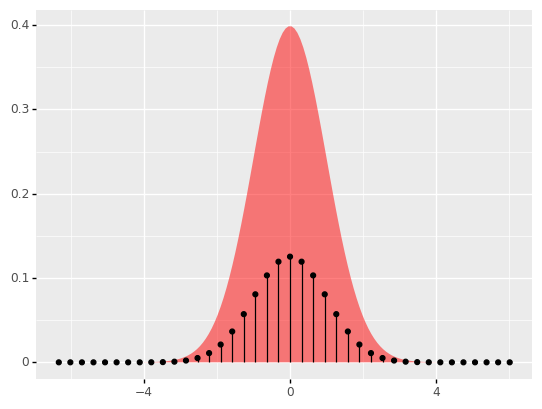

<ggplot: (681750914)>

In [3]:
p = ggplot(pdf)
p = p + geom_area(aes(x = 'x', y = 'density'), position=position_identity, alpha = 0.5, fill = 'red')
p = p + geom_point(aes(x = 'x', y = 'probability'), data = pmf)
p = p + geom_segment(aes(x = 'x', xend = 'x', yend = 'probability'), y=0, data = pmf)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)
p.save('pdf_vs_pmf.pdf', path='results', height=6, width=12, verbose=False)

### Explanation 

Definitions of both functions lead to different and usually incompatible normalisation constraints:   
* The definition of the probability density function assures that the area under the function is equal to one.
* The definition of the probability mass function assures that the sum of all peaks is equal to one.

It is straightforward to check that the density function does not follow sum normalisation:

In [4]:
norm.pdf(pmf['x']).sum()

3.162277659106854

At the same time, the probability mass function can be used to define a histogram with the following bar widths:

In [5]:
pmf.loc[1:39, 'x'].values - pmf.loc[0:38,'x'].values

array([0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
       0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
       0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
       0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
       0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
       0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
       0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
       0.31622777, 0.31622777, 0.31622777, 0.31622777])

By normalising densities with bar widths from the probability mass function, we can build a density plot with an area under the line equal to one.

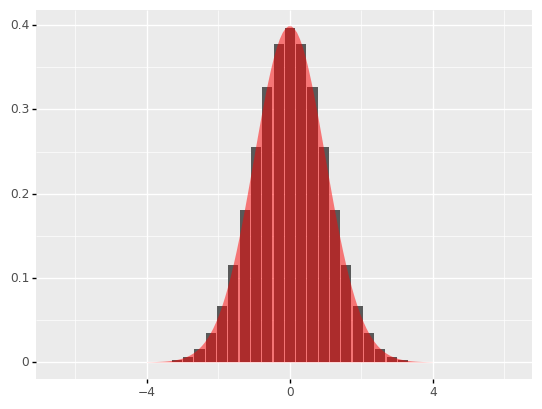

<ggplot: (682003026)>

In [6]:
pmf = pmf.assign(density =  lambda df: df['probability']/0.31622777)

p = ggplot(pdf)
p = p + geom_col(aes(x = 'x',  y = 'density'), data = pmf)
p = p + geom_area(aes(x = 'x', y = 'density'), position=position_identity, alpha = 0.5, fill = 'red')
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

Similarly, we can compress the probability density function into probability mass function if we make sure that the sum of densities equals one. This is a crude estimation and should be replaced with something more clever in the home exercise.

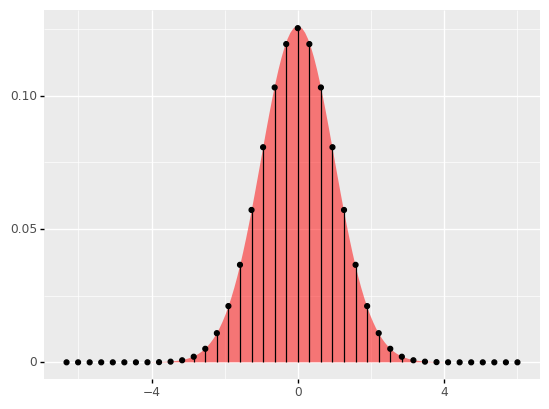

<ggplot: (682029575)>

In [7]:
pdf = pdf.assign(probability =  lambda df: df['density']/norm.pdf(pmf['x']).sum())

p = ggplot(pdf)
p = p + geom_area(aes(x = 'x', y = 'probability'), position=position_identity, alpha = 0.5, fill = 'red')
p = p + geom_point(aes(x = 'x', y = 'probability'), data = pmf)
p = p + geom_segment(aes(x = 'x', xend = 'x', yend = 'probability'), y=0, data = pmf)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

## II. Standard normal distribution

In order to construct white Gaussian noise we need a standard normal distribution – a univariate normal distribution $\mathcal{N}(0, 1)$ with mean $0$ and standard deviation $1$. 

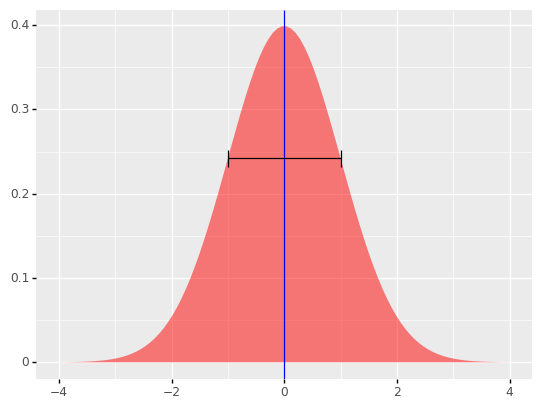

<ggplot: (681904746)>

In [8]:
pdf = DataFrame({'x':np.linspace(-4, 4, 100)}).assign(density = lambda df: norm.pdf(df['x']))

p = ggplot(pdf)
p = p + geom_area(aes(x = 'x', y = 'density'), position=position_identity, alpha = 0.5, fill = 'red')
p = p + geom_vline(xintercept = 0, color='blue')
p = p + geom_errorbarh(aes(y = 'y'), data = DataFrame({'y': [norm.pdf(1)]}), xmin=-1, xmax=1, height = 0.02)
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)
p.save('standard_normal_distribution.pdf', path='results', height=6, width=12, verbose=False)

## III. Affine transformations of standard normal distribution

Let us derive graphically an approximate density function for $y=\sigma x + \mu$ where $x\sim\mathcal{N}(0,1)$.
First let us split the $x$-axis into small segments using a grid:

In [9]:
pdf =  DataFrame({'x': np.linspace(-4, 4, 400)}).assign(density = lambda df: norm.pdf(df['x']))
xgrid = DataFrame({'x': np.linspace(-3, 3, 9)}).assign(density = lambda df: norm.pdf(df['x']))

### Approximation for the x variable

* For each grid point $x_i$ we can approximate the probability that $x$  falls into the segment $[x_i-\Delta,x_i+\Delta]$ by the quantity $2\Delta\cdot p(x_i)$.
* The latter is equal to the area of the columns in the figure below. The approximation becomes more and more precise when $\Delta\to 0$.

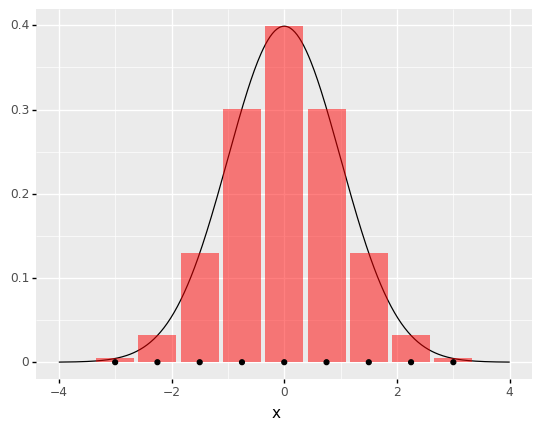

<ggplot: (681743436)>

In [10]:
p = ggplot(xgrid)
p = p + geom_line(aes(x = 'x', y = 'density'), data = pdf)
p = p + geom_col(aes(x = 'x', y = 'density'), alpha = 0.5, fill = 'red')
p = p + geom_point(aes(x = 'x'), y=0)
p = p + scale_y_continuous(name='')
p.save('1d_source_distribution.pdf', path='results', height=6, width=6, verbose=False)
display(p)

### Approximation for the y variable

* As $y=\sigma x+\mu$ then $y$ falls into $[\sigma (x_i-\Delta) + \mu,\sigma (x_i+\Delta) + \mu]$ when $x$ is in the segment $[x_i-\Delta,x_i+\Delta]$. 
* The density $q(y)$ manifests from noting that the probabilities that $y$ and $x$ fall into corresponding segments are equal: $2\sigma\Delta\cdot q(y)= 2\Delta\cdot p(x)$.
* As a result, we can express the density for $y$: 

\begin{align*}
q(y)=\frac{p(x)}{\sigma}=\frac{1}{\sqrt{2\pi}\sigma}\cdot\exp{\frac{(y-\mu)^2}{2\sigma^2}}\enspace.
\end{align*}

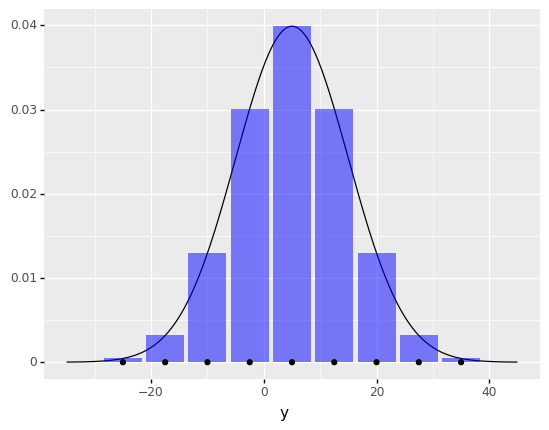

<ggplot: (682208615)>

In [11]:
mu = 5
sigma = 10

ygrid = (xgrid
         .assign(y = lambda df: sigma * df['x'] + mu)
         .assign(y_density = lambda df: df['density']/sigma)
         .rename(columns = {'density': 'x_density'}))

pdf = (DataFrame({'y': np.linspace(-4*sigma + mu, 4*sigma + mu, 400)})
       .assign(density = lambda df: norm(loc =  mu, scale = sigma).pdf(df['y'])))

p = ggplot(ygrid)
p = p + geom_line(aes(x = 'y', y = 'density'), data = pdf)
p = p + geom_col(aes(x = 'y', y = 'y_density'), alpha = 0.5, fill = 'blue')
p = p + geom_point(aes(x = 'y'), y = 0)
p = p + scale_y_continuous(name='')
display(p)
p.save('1d_target_distribution.pdf', path='results', height=6, width=6, verbose=False)

Indeed, the shifted density approximation follows the true density of $\mathcal{N}(\mu=5, \sigma=10)$.

# Homework

## 6.1 Standard normal distribution as limiting distribution (<font color='red'>1p</font>)

It is known that binomial distribution [`binom(n, p)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) converges to the normal distribution. Use moment matching and affine transformation to define variable $y=ax+b$ such that for $x\sim\mathsf{Binom}(n,p)$, the variable $y$ converges to the normal distribution $\mathcal{N}(0, 1)$.
You can use parameters $n=30$ $p=0.75$ for the following visualisations:

* Draw a spike plot for the probability mass function of $y$ and rescale the density function of $\mathcal{N}(0,1)$ so that heights match. 
* Draw a density plot for the standard normal distribution $\mathcal{N}(0,1)$ and represent the probability mass function of $y$ in a bar plot so that heights match again.

## 6.2 Histograms versus probability density and mass functions (<font color='red'>1p</font>)

We know that the binomial distribution converges to the normal distribution. For practical purposes the variable 

\begin{align*}
y=\frac{2} {\sqrt{n}}\cdot (k-np), \qquad k\sim\mathsf{Binom}(n, p) 
\end{align*}

is quite close to the normal distribution $\mathcal{N}(0,1)$. However, one of the functions is continuous and the other is discrete. Thus their histograms behave quite differently for small bin sizes. 
To see this, consider a range $y\in[-4,4]$ with bin sizes $\Delta y\in\{1, 0.5, 0.01\}$, sample the corresponding data and draw the histograms.

* Draw enough data from the discrete distribution $y$ to get a stable histogram for different bin sizes.
* Draw enough data from the continuous distribution $\mathcal{N}(0,1)$ to get a stable histogram for different bin sizes.
* To make histograms comparable use frequency on $y$-axis and organise graphs as $2\times 3$ facets. 

**Hint:** Plotnine and ggplot support only counts and densities as scaling for the $y$-axis whereas we need frequencies to see the effect. Thus, we need to implement the aggregation by ourselves. Doing so also reduces the running time for `ggplot` routines.

,k,count,y,freq
22,8,2,-3.794733,0.02
21,9,3,-3.478505,0.03
19,10,7,-3.162278,0.07
17,11,19,-2.846050,0.19
16,12,57,-2.529822,0.57


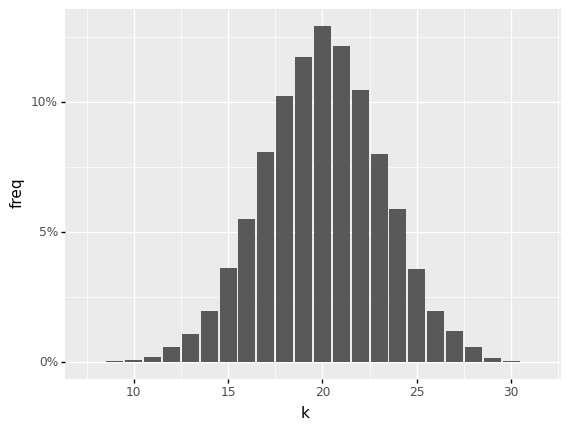

<ggplot: (683847452)>

In [16]:
counts = (DataFrame(Series(binom(n=40, p=1/2).rvs(size=10000)).value_counts())
          .reset_index()
          .rename(columns={'index':'k', 0:'count'})
          .sort_values('k')
          .assign(y = lambda df: 2/np.sqrt(40)*(df['k'] - 20))
          .assign(freq = lambda df: df['count']/df['count'].sum() * 100)
         )

display(head(counts))

p = ggplot(counts)
p = p + geom_col(aes(x = 'k', y = 'freq'))
p = p + scale_y_continuous(labels=lambda l: ["%d%%" % (v) for v in l])
display(p)

**Hint:**
* Use `df.groupby(['a', 'b]).count()` for basic data aggregation. 
* Use `geom_tile(aes(x='x', y='y', fill='count'))` with `scale_fill_gray()` to visualise the plot.
* Densities can be computed from frequencies by dividing by the area of the corresponding tile.

In [2]:
%config IPCompleter.greedy=True